## Importing data (Alex updated: 4/30/19)

In [26]:
import numpy as np

# Image processing tools
import skimage
import skimage.filters

import pandas as pd
import scipy.optimize
import scipy.stats as st
import numba
import itertools

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

from numpy.linalg import inv

from tqdm import tqdm, trange
from scipy import special, optimize
from scipy import integrate

import plotly.offline as py
import plotly.graph_objs as go
import plotly
#plotly.tools.set_credentials_file(username='AYChoi', api_key='ZacDa7fKo8hfiELPfs57')
plotly.tools.set_credentials_file(username='AlexanderYChoi', api_key='VyLt05wzc89iXwSC82FO')

Load the e-ph matrix elements data. The two numbers reported at the end should be the same. If they are not, there are duplicate e-ph elements. It's VERY IMPORTANT to note that the g elements here are actually |g|^2 which is why they are real numbers.

In [16]:
data = pd.read_csv('gaas.eph_matrix', sep='\t',header= None,skiprows=(0,1))
data.columns = ['0']
data_array = data['0'].values
new_array = np.zeros((len(data_array),7))
for i1 in trange(len(data_array)):
    new_array[i1,:] = data_array[i1].split()
    
g_df = pd.DataFrame(data=new_array,columns = ['k_inds','q_inds','k+q_inds','m_band','n_band','im_mode','g_element'])
g_df[['k_inds','q_inds','k+q_inds','m_band','n_band','im_mode']] = g_df[['k_inds','q_inds','k+q_inds','m_band','n_band','im_mode']].apply(pd.to_numeric,downcast = 'integer')
len(g_df[['k_inds','q_inds','k+q_inds','m_band','n_band','im_mode','g_element']]),len(g_df[['k_inds','q_inds','k+q_inds','m_band','n_band','im_mode','g_element']].drop_duplicates())

100%|██████████| 7854608/7854608 [00:15<00:00, 494019.89it/s]


(7854608, 7854608)

Now load the k-point indices, q-point indices, k-point energies, phonon energies into dataframes.

In [17]:
kpts = pd.read_csv('gaas.kpts', sep='\t',header= None)
kpts.columns = ['0']
kpts_array = kpts['0'].values
new_kpt_array = np.zeros((len(kpts_array),4))
for i1 in trange(len(kpts_array)):
    new_kpt_array[i1,:] = kpts_array[i1].split()
    
kpts_df = pd.DataFrame(data=new_kpt_array,columns = ['k_inds','b1','b2','b3'])
kpts_df[['k_inds']] = kpts_df[['k_inds']].apply(pd.to_numeric,downcast = 'integer')
kpts_df.head()

100%|██████████| 2213/2213 [00:00<00:00, 432444.78it/s]


,k_inds,b1,b2,b3
0,1,0.0,0.0,0.00
1,2,0.0,0.0,0.01
2,3,0.0,0.0,0.02
3,4,0.0,0.0,0.03
4,5,0.0,0.0,0.04


In [18]:
enk = pd.read_csv('gaas.enk', sep='\t',header= None)
enk.columns = ['0']
enk_array = enk['0'].values
new_enk_array = np.zeros((len(enk_array),3))
for i1 in trange(len(enk_array)):
    new_enk_array[i1,:] = enk_array[i1].split()
    
enk_df = pd.DataFrame(data=new_enk_array,columns = ['k_inds','band_inds','energy [Ryd]'])
enk_df[['k_inds','band_inds']] = enk_df[['k_inds','band_inds']].apply(pd.to_numeric,downcast = 'integer')
enk_df.head()

100%|██████████| 2213/2213 [00:00<00:00, 592341.72it/s]


,k_inds,band_inds,energy [Ryd]
0,1,1,0.445788
1,2,1,0.447866
2,3,1,0.453308
3,4,1,0.460652
4,5,1,0.468793


In [19]:
enq = pd.read_csv('gaas.enq', sep='\t',header= None)
enq.columns = ['0']
enq_array = enq['0'].values
new_enq_array = np.zeros((len(enq_array),3))
for i1 in trange(len(enq_array)):
    new_enq_array[i1,:] = enq_array[i1].split()
    
enq_df = pd.DataFrame(data=new_enq_array,columns = ['q_inds','im_mode','energy [Ryd]'])
enq_df[['q_inds','im_mode']] = enq_df[['q_inds','im_mode']].apply(pd.to_numeric,downcast = 'integer')
enq_df.head()

100%|██████████| 126480/126480 [00:00<00:00, 626632.23it/s]


,q_inds,im_mode,energy [Ryd]
0,1,1,0.000020
1,1,2,0.000026
2,1,3,0.000054
3,1,4,0.002432
4,1,5,0.002432


In [20]:
qpts = pd.read_csv('gaas.qpts', sep='\t',header= None)
qpts.columns = ['0']
qpts_array = qpts['0'].values
new_qpt_array = np.zeros((len(qpts_array),4))

for i1 in trange(len(qpts_array)):
    new_qpt_array[i1,:] = qpts_array[i1].split()
    
qpts_df = pd.DataFrame(data=new_qpt_array,columns = ['q_inds','b1','b2','b3'])
qpts_df[['q_inds']] = qpts_df[['q_inds']].apply(pd.to_numeric,downcast = 'integer')
qpts_df.head()

100%|██████████| 21080/21080 [00:00<00:00, 561046.81it/s]


,q_inds,b1,b2,b3
0,1,0.0,0.0,0.01
1,2,0.0,0.0,0.02
2,3,0.0,0.0,0.03
3,4,0.0,0.0,0.04
4,5,0.0,0.0,0.05


## Data Processing (Alex Updated: 4/30)

In [21]:
def cartesian_q_points(qpts_df):
    """
    Given a dataframe containing indexed q-points in terms of the crystal lattice vector, return the dataframe with cartesian q coordinates.     
    Parameters:
    -----------
    qpts_df : pandas dataframe containing:
        
        q_inds : vector_like, shape (n,1)
        Index of q point
        
        kx : vector_like, shape (n,1)
        x-coordinate in momentum space [1/A]    
        
        ky : vector_like, shape (n,1)
        y-coordinate in momentum space [1/A]  
        
        kz : vector_like, shape (n,1)
        z-coordinate in momentum space [1/A]
        
    For FCC lattice, use the momentum space primitive vectors as per:
    http://lampx.tugraz.at/~hadley/ss1/bzones/fcc.php
    
    b1 = 2 pi/a (kx - ky + kz)
    b2 = 2 pi/a (kx + ky - kz)
    b3 = 2 pi/a (-kx + ky + kz)
    
    Returns:
    --------
    cart_kpts_df : pandas dataframe containing:
    
        q_inds : vector_like, shape (n,1)
        Index of q point
        
        kx : vector_like, shape (n,1)
        x-coordinate in Cartesian momentum space [1/m]    
        
        ky : vector_like, shape (n,1)
        y-coordinate in Cartesian momentum space [1/m]  
        
        kz : vector_like, shape (n,1)
        z-coordinate in Cartesian momentum space [1/m]  
    """
    
    # Need a lattice constant for GaAs. This is obviously somewhat sensitive to temperature.
    a = 5.556 #[A]
    
    cartesian_df = pd.DataFrame(columns = ['q_inds','kx [1/A]','ky [1/A]','kz [1/A]'])
    
    con1 = pd.DataFrame(columns = ['kx [1/A]','ky [1/A]','kz [1/A]'])
    con1['kx [1/A]'] = np.ones(len(qpts_df))*(-2*np.pi/a)
    con1['ky [1/A]'] = np.ones(len(qpts_df))*(-2*np.pi/a)
    con1['kz [1/A]'] = np.ones(len(qpts_df))*(2*np.pi/a)

    con2 = con1.copy(deep=True)
    con2['kx [1/A]'] = con2['kx [1/A]'].values*-1
    con2['ky [1/A]'] = con2['ky [1/A]'].values*-1

    con3 = con1.copy(deep=True)
    con3['ky [1/A]'] = con2['ky [1/A]'].values
    con3['kz [1/A]'] = con3['kz [1/A]'].values*-1
    
    
    cartesian_df['kx [1/A]'] = np.multiply(qpts_df['b1'].values,(con1['kx [1/A]'].values)) + np.multiply(qpts_df['b2'].values,(con2['kx [1/A]'].values)) + np.multiply(qpts_df['b3'].values,(con3['kx [1/A]'].values))
    cartesian_df['ky [1/A]'] = np.multiply(qpts_df['b1'].values,(con1['ky [1/A]'].values)) + np.multiply(qpts_df['b2'].values,(con2['ky [1/A]'].values)) + np.multiply(qpts_df['b3'].values,(con3['ky [1/A]'].values))
    cartesian_df['kz [1/A]'] = np.multiply(qpts_df['b1'].values,(con1['kz [1/A]'].values)) + np.multiply(qpts_df['b2'].values,(con2['kz [1/A]'].values)) + np.multiply(qpts_df['b3'].values,(con3['kz [1/A]'].values))

    cartesian_df['q_inds'] = qpts_df['q_inds'].values
    return cartesian_df

In [22]:
a = 5.556 #[A]

In [23]:
kvel = pd.read_csv('gaas.vel', sep='\t',header= None,skiprows=[0,1,2])
kvel.columns = ['0']
kvel_array = kvel['0'].values
new_kvel_array = np.zeros((len(kvel_array),10))
for i1 in trange(len(kvel_array)):
    new_kvel_array[i1,:] = kvel_array[i1].split()
    
kvel_df = pd.DataFrame(data=new_kvel_array,columns = ['k_inds','bands','energy','kx [2pi/alat]','ky [2pi/alat]','kz [2pi/alat]','vx_dir','vy_dir','vz_dir','v_mag [m/s]'])
kvel_df[['k_inds']] = kvel_df[['k_inds']].apply(pd.to_numeric,downcast = 'integer')

kvel_edit = kvel_df.copy(deep=True)

kx_plus = kvel_df['kx [2pi/alat]'] > 0.5
kx_minus = kvel_df['kx [2pi/alat]'] < -0.5

ky_plus = kvel_df['ky [2pi/alat]'] > 0.5
ky_minus = kvel_df['ky [2pi/alat]'] < -0.5

kz_plus = kvel_df['kz [2pi/alat]'] > 0.5
kz_minus = kvel_df['kz [2pi/alat]'] < -0.5

kvel_edit.loc[kx_plus,'kx [2pi/alat]'] = kvel_df.loc[kx_plus,'kx [2pi/alat]'] -1
kvel_edit.loc[kx_minus,'kx [2pi/alat]'] = kvel_df.loc[kx_minus,'kx [2pi/alat]'] +1

kvel_edit.loc[ky_plus,'ky [2pi/alat]'] = kvel_df.loc[ky_plus,'ky [2pi/alat]'] -1
kvel_edit.loc[ky_minus,'ky [2pi/alat]'] = kvel_df.loc[ky_minus,'ky [2pi/alat]'] +1

kvel_edit.loc[kz_plus,'kz [2pi/alat]'] = kvel_df.loc[kz_plus,'kz [2pi/alat]'] -1
kvel_edit.loc[kz_minus,'kz [2pi/alat]'] = kvel_df.loc[kz_minus,'kz [2pi/alat]'] +1

kvel_df = kvel_edit.copy(deep=True)
kvel_df.head()

cart_kpts_df = kvel_df.copy(deep=True)
cart_kpts_df['kx [2pi/alat]'] = cart_kpts_df['kx [2pi/alat]'].values*2*np.pi/a
cart_kpts_df['ky [2pi/alat]'] = cart_kpts_df['ky [2pi/alat]'].values*2*np.pi/a
cart_kpts_df['kz [2pi/alat]'] = cart_kpts_df['kz [2pi/alat]'].values*2*np.pi/a

cart_kpts_df.columns = ['k_inds', 'bands', 'energy', 'kx [1/A]', 'ky [1/A]','kz [1/A]', 'vx_dir', 'vy_dir', 'vz_dir', 'v_mag [m/s]']


100%|██████████| 2213/2213 [00:00<00:00, 259549.10it/s]


In [24]:
cart_qpts_df = cartesian_q_points(qpts_df)

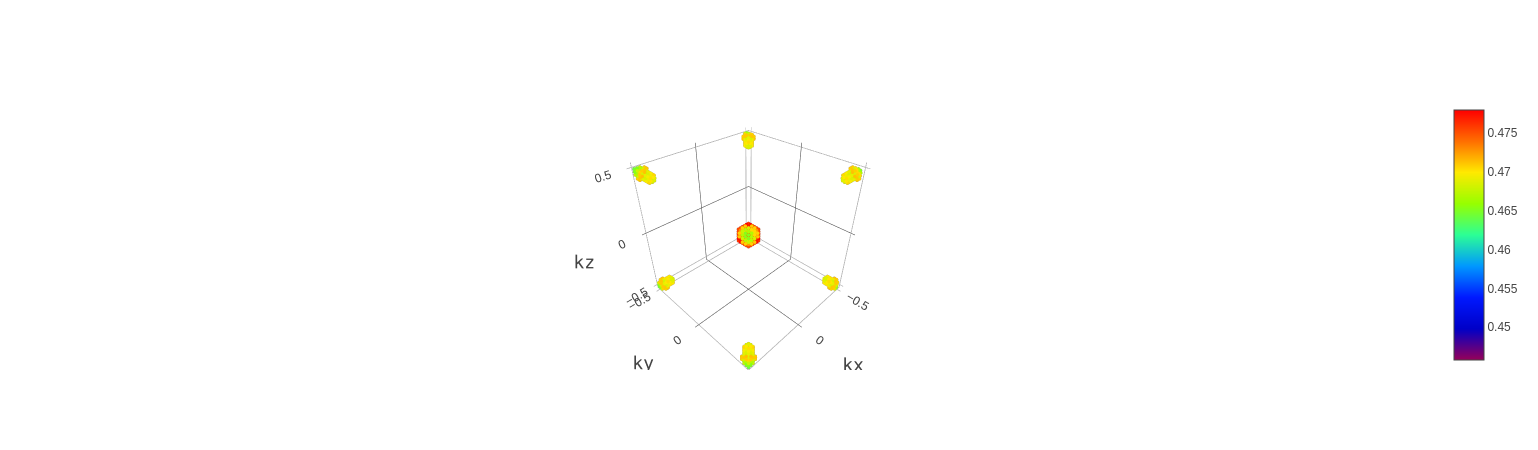

In [27]:
trace1 = go.Scatter3d(
    x=cart_kpts_df['kx [1/A]'].values/(2*np.pi/(a)),
    y=cart_kpts_df['ky [1/A]'].values/(2*np.pi/(a)),
    z=cart_kpts_df['kz [1/A]'].values/(2*np.pi/(a)),
    mode='markers',
    marker=dict(
        size=2,
        color=enk_df['energy [Ryd]'],
        colorscale='Rainbow',
        showscale=True,
        opacity=1
    )
)

trace2 = go.Scatter

data = [trace1]
layout = go.Layout(
                    scene = dict(
                    xaxis = dict(
                        title='kx',titlefont = dict(family='Oswald, monospace',size=18)),
                    yaxis = dict(
                        title='ky',titlefont = dict(family='Oswald, monospace',size=18)),
                    zaxis = dict(
                        title='kz',titlefont = dict(family='Oswald, monospace',size=18)),))
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='simple-3d-scatter')

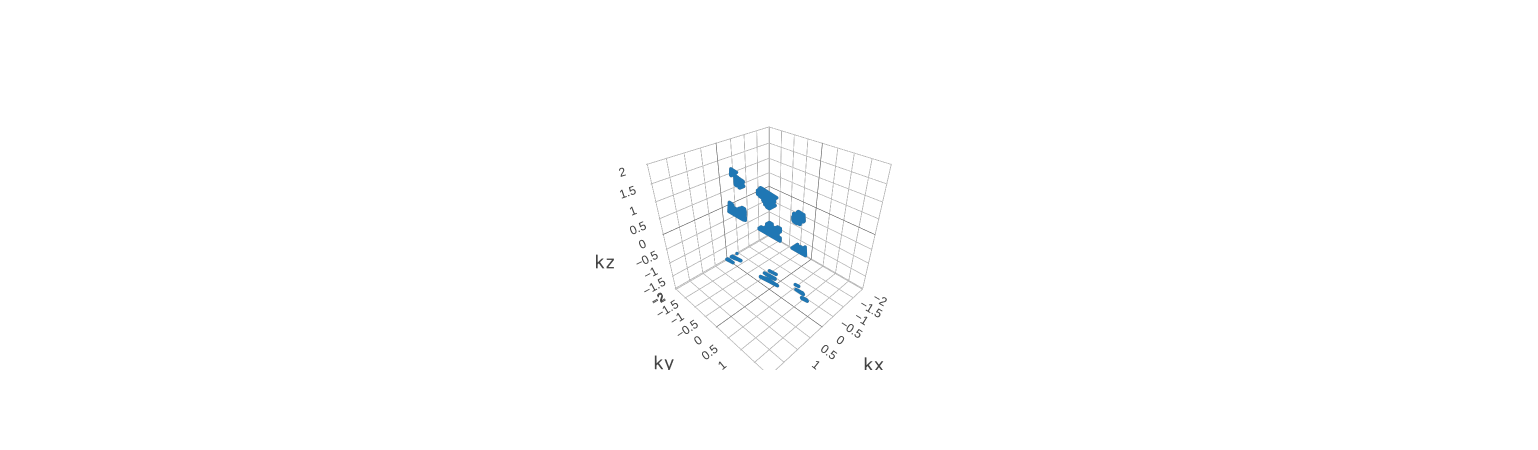

In [28]:
trace1 = go.Scatter3d(
    x=cart_qpts_df['kx [1/A]'].values*(2*np.pi/(a)),
    y=cart_qpts_df['ky [1/A]'].values*(2*np.pi/(a)),
    z=cart_qpts_df['kz [1/A]'].values*(2*np.pi/(a)),
    mode='markers',
    marker=dict(
        size=2,
        opacity=1
    )
)

data = [trace1]
layout = go.Layout(
                    scene = dict(
                    xaxis = dict(
                        title='kx',titlefont = dict(family='Oswald, monospace',size=18)),
                    yaxis = dict(
                        title='ky',titlefont = dict(family='Oswald, monospace',size=18)),
                    zaxis = dict(
                        title='kz',titlefont = dict(family='Oswald, monospace',size=18)),))
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='simple-3d-scatter')

In [ ]:
def fermi_distribution(g_df,mu,T):
    """
    This function takes a list of k-point indices and returns the Fermi-distributions and energies associated with each k-point on that list. The Fermi distributions are calculated with respect to a particular chemical potential.      
    Parameters:
    -----------
    
    g_df : pandas dataframe containing:
    
        k_inds : vector_like, shape (n,1)
        Index of k point (pre-collision)
        
        q_inds : vector_like, shape (n,1)
        Index of q point
        
        k+q_inds : vector_like, shape (n,1)
        Index of k point (post-collision)
        
        m_band : vector_like, shape (n,1)
        Band index of post-collision state
        
        n_band : vector_like, shape (n,1)
        Band index of pre-collision state
        
        im_mode : vector_like, shape (n,1)
        Polarization of phonon mode
        
        g_element : vector_like, shape (n,1)
        E-ph matrix element
        
        k_energy : vector_like, shape (n,1)
        Energy of the pre collision state
        
        k+q_energy : vector_like, shape (n,1)
        Energy of the post collision state
        
        
    mu : scalar
    Chemical potential of electronic states [eV]
    
    T : scalar
    Lattice temperature in Kelvin
    
    Returns:
    --------
    
    g_df : pandas dataframe containing:

        k_inds : vector_like, shape (n,1)
        Index of k point (pre-collision)
        
        q_inds : vector_like, shape (n,1)
        Index of q point
        
        k+q_inds : vector_like, shape (n,1)
        Index of k point (post-collision)
        
        m_band : vector_like, shape (n,1)
        Band index of post-collision state
        
        n_band : vector_like, shape (n,1)
        Band index of pre-collision state
        
        im_mode : vector_like, shape (n,1)
        Polarization of phonon mode
        
        g_element : vector_like, shape (n,1)
        E-ph matrix element
        
        k_fermi_dist : vector_like, shape (n,1)
        Fermi distribution of pre collision state
        
        k+q_fermi_dist : vector_like, shape (n,1)
        Fermi distribution of post collision state
        
        k_energy : vector_like, shape (n,1)
        Energy of the pre collision state
        
        k+q_energy : vector_like, shape (n,1)
        Energy of the post collision state
         
    """
    # Physical constants    
    e = 1.602*10**(-19) # fundamental electronic charge [C]
    kb = 1.38064852*10**(-23); # Boltzmann constant in SI [m^2 kg s^-2 K^-1]


    g_df['k_FD'] = (np.exp((g_df['k_en [eV]'].values*e - mu*e)/(kb*T)) + 1)**(-1)
    g_df['k+q_FD'] = (np.exp((g_df['k+q_en [eV]'].values*e - mu*e)/(kb*T)) + 1)**(-1)

    return g_df

In [ ]:
def bose_distribution(g_df,T):
    """
    This function takes a list of q-point indices and returns the Bose-Einstein distributions associated with each q-point on that list.    
    Parameters:
    -----------
    
    g_df : pandas dataframe containing:
    
        k_inds : vector_like, shape (n,1)
        Index of k point (pre-collision)
        
        q_inds : vector_like, shape (n,1)
        Index of q point
        
        k+q_inds : vector_like, shape (n,1)
        Index of k point (post-collision)
        
        m_band : vector_like, shape (n,1)
        Band index of post-collision state
        
        n_band : vector_like, shape (n,1)
        Band index of pre-collision state
        
        im_mode : vector_like, shape (n,1)
        Polarization of phonon mode
        
        g_element : vector_like, shape (n,1)
        E-ph matrix element
        
        k_energy : vector_like, shape (n,1)
        Energy of the pre collision state
        
        k+q_energy : vector_like, shape (n,1)
        Energy of the post collision state
        
        
    mu : scalar
    Chemical potential of electronic states [eV]
    
    T : scalar
    Lattice temperature in Kelvin
    
    Returns:
    --------
    
    g_df : pandas dataframe containing:

        k_inds : vector_like, shape (n,1)
        Index of k point (pre-collision)
        
        q_inds : vector_like, shape (n,1)
        Index of q point
        
        k+q_inds : vector_like, shape (n,1)
        Index of k point (post-collision)
        
        m_band : vector_like, shape (n,1)
        Band index of post-collision state
        
        n_band : vector_like, shape (n,1)
        Band index of pre-collision state
        
        im_mode : vector_like, shape (n,1)
        Polarization of phonon mode
        
        g_element : vector_like, shape (n,1)
        E-ph matrix element
        
        BE : vector_like, shape (n,1)
        Bose-einstein distribution
         
    """
    # Physical constants    
    e = 1.602*10**(-19) # fundamental electronic charge [C]
    kb = 1.38064852*10**(-23); # Boltzmann constant in SI [m^2 kg s^-2 K^-1]


    g_df['BE'] = (np.exp((g_df['q_en [eV]'].values*e)/(kb*T)) - 1)**(-1)
    return g_df

In [ ]:
def fermionic_processing(g_df,cart_kpts_df,enk_df,mu,T):
    """
    This function takes a list of k-point indices and returns the Fermi-distributions and energies associated with each k-point on that list. The Fermi distributions are calculated with respect to a particular chemical potential.      
    Parameters:
    -----------
    
    g_df : pandas dataframe containing:
    
        k_inds : vector_like, shape (n,1)
        Index of k point (pre-collision)
        
        q_inds : vector_like, shape (n,1)
        Index of q point
        
        k+q_inds : vector_like, shape (n,1)
        Index of k point (post-collision)
        
        m_band : vector_like, shape (n,1)
        Band index of post-collision state
        
        n_band : vector_like, shape (n,1)
        Band index of pre-collision state
        
        im_mode : vector_like, shape (n,1)
        Polarization of phonon mode
        
        g_element : vector_like, shape (n,1)
        E-ph matrix element
               
    cart_kpts_df : pandas dataframe containing:
    
        k_inds : vector_like, shape (n,1)
        Index of k point
        
        kx : vector_like, shape (n,1)
        x-coordinate in Cartesian momentum space [1/m]    
        
        ky : vector_like, shape (n,1)
        y-coordinate in Cartesian momentum space [1/m]  
        
        kz : vector_like, shape (n,1)
        z-coordinate in Cartesian momentum space [1/m]
        
    enk_df : pandas dataframe containing

        k_inds : vector_like, shape (n,1)
        Index of k point
        
        band_inds : vector_like, shape (n,1)
        Band index
        
        energy [Ryd] : vector_like, shape (n,1)
        Energy associated with k point in Rydberg units
        
        
    mu : scalar
    Chemical potential of electronic states [eV]
    
    T : scalar
    Lattice temperature in Kelvin
    
    Returns:
    --------
    
    g_df : pandas dataframe containing:

        k_inds : vector_like, shape (n,1)
        Index of k point (pre-collision)
        
        q_inds : vector_like, shape (n,1)
        Index of q point
        
        k+q_inds : vector_like, shape (n,1)
        Index of k point (post-collision)
        
        m_band : vector_like, shape (n,1)
        Band index of post-collision state
        
        n_band : vector_like, shape (n,1)
        Band index of pre-collision state
        
        im_mode : vector_like, shape (n,1)
        Polarization of phonon mode
        
        g_element : vector_like, shape (n,1)
        E-ph matrix element
        
        k_fermi_dist : vector_like, shape (n,1)
        Fermi distribution of pre collision state
        
        k+q_fermi_dist : vector_like, shape (n,1)
        Fermi distribution of post collision state
        
        k_energy : vector_like, shape (n,1)
        Energy of the pre collision state
        
        k+q_energy : vector_like, shape (n,1)
        Energy of the post collision state
         
    """
    
    # Physical constants
    e = 1.602*10**(-19) # fundamental electronic charge [C]
    kb = 1.38064852*10**(-23); # Boltzmann constant in SI [m^2 kg s^-2 K^-1]
    
    index_vector = cart_kpts_df['k_inds'].values    
    g_df['k_en [eV]'] = np.zeros(len(g_df))
    g_df['k+q_en [eV]'] = np.zeros(len(g_df))
    g_df['collision_state'] = np.zeros(len(g_df))
    
    for i1 in trange(len(cart_kpts_df)):
        index = index_vector[i1]
        
        g_slice_k = g_df['k_inds'] == index        
        g_slice_kq = g_df['k+q_inds'] == index
        
        k_slice = cart_kpts_df['k_inds'] == index
        enk_slice = enk_df['k_inds'] == index
        
        g_df.loc[g_slice_k,'k_en [eV]'] = enk_df.loc[enk_slice,'energy [Ryd]'].values*13.6056980659 
        g_df.loc[g_slice_kq,'k+q_en [eV]'] = enk_df.loc[enk_slice,'energy [Ryd]'].values*13.6056980659
        
    abs_inds = g_df['k_en [eV]'] < g_df['k+q_en [eV]'] #absorbed indices
    ems_inds = g_df['k_en [eV]'] > g_df['k+q_en [eV]'] #emission indices
    
    g_df.loc[abs_inds,'collision_state'] = 1
    g_df.loc[ems_inds,'collision_state'] = -1
    
    g_df = fermi_distribution(g_df,mu, T)
    
    return g_df

In [ ]:
g_df = fermionic_processing(g_df,cart_kpts_df,enk_df,5.780,300)

In [ ]:
def bosonic_processing(g_df,cart_qpts_df,enq_df,T):
    """
    This function takes a list of k-point indices and returns the Fermi-distributions and energies associated with each k-point on that list. The Fermi distributions are calculated with respect to a particular chemical potential.      
    Parameters:
    -----------
    
    g_df : pandas dataframe containing:
    
        k_inds : vector_like, shape (n,1)
        Index of k point (pre-collision)
        
        q_inds : vector_like, shape (n,1)
        Index of q point
        
        k+q_inds : vector_like, shape (n,1)
        Index of k point (post-collision)
        
        m_band : vector_like, shape (n,1)
        Band index of post-collision state
        
        n_band : vector_like, shape (n,1)
        Band index of pre-collision state
        
        im_mode : vector_like, shape (n,1)
        Polarization of phonon mode
        
        g_element : vector_like, shape (n,1)
        E-ph matrix element
               
    cart_qpts_df : pandas dataframe containing:
    
        q_inds : vector_like, shape (n,1)
        Index of q point
        
        kx : vector_like, shape (n,1)
        x-coordinate in Cartesian momentum space [1/m]    
        
        ky : vector_like, shape (n,1)
        y-coordinate in Cartesian momentum space [1/m]  
        
        kz : vector_like, shape (n,1)
        z-coordinate in Cartesian momentum space [1/m]
        
    enq_df : pandas dataframe containing

        k_inds : vector_like, shape (n,1)
        Index of k point
        
        im_mode : vector_like, shape (n,1)
        Phonon polarization index
        
        energy [Ryd] : vector_like, shape (n,1)
        Energy associated with k point in Rydberg units
        
            
    T : scalar
    Lattice temperature in Kelvin
    
    Returns:
    --------
    
    g_df : pandas dataframe containing:

        k_inds : vector_like, shape (n,1)
        Index of k point (pre-collision)
        
        q_inds : vector_like, shape (n,1)
        Index of q point
        
        k+q_inds : vector_like, shape (n,1)
        Index of k point (post-collision)
        
        m_band : vector_like, shape (n,1)
        Band index of post-collision state
        
        n_band : vector_like, shape (n,1)
        Band index of pre-collision state
        
        im_mode : vector_like, shape (n,1)
        Polarization of phonon mode
        
        g_element : vector_like, shape (n,1)
        E-ph matrix element
        
        k_fermi_dist : vector_like, shape (n,1)
        Fermi distribution of pre collision state
        
        k+q_fermi_dist : vector_like, shape (n,1)
        Fermi distribution of post collision state
        
        k_energy : vector_like, shape (n,1)
        Energy of the pre collision state
        
        k+q_energy : vector_like, shape (n,1)
        Energy of the post collision state
         
    """
    
    # Physical constants
    e = 1.602*10**(-19) # fundamental electronic charge [C]
    kb = 1.38064852*10**(-23); # Boltzmann constant in SI [m^2 kg s^-2 K^-1]
    
    index_vector = cart_qpts_df['q_inds'].values
    polar_vector = np.unique(g_df['im_mode'].values)
    
    g_df['q_en [eV]'] = np.ones(len(g_df))
    
    for i1 in trange(len(cart_qpts_df)):
    #for i1 in trange(10):

        index = index_vector[i1]
        index_slice = enq_df['q_inds'].values == index
        
        g_slice_q = g_df['q_inds'] == index        
                
        for i2 in range(len(polar_vector)):
            polar_index = polar_vector[i2]
            polar_slice = enq_df['im_mode'].values == polar_index
            hybrid_slice = np.multiply(index_slice,polar_slice)
            g_slice_im = g_df['im_mode'] == polar_index
            hybrid_g_slice = np.multiply(g_slice_q,g_slice_im)

            g_df.loc[hybrid_g_slice,'q_en [eV]'] = enq_df.loc[hybrid_slice,'energy [Ryd]'].values*13.6056980659
            
            #print(enq_df.loc[hybrid_slice,'energy [Ryd]'].values)
        
    
    g_df = bose_distribution(g_df, T)
    
    return g_df

In [ ]:
g_df = bosonic_processing(g_df,cart_qpts_df,enq_df,300)

In [ ]:
g_df_ems = g_df.loc[g_df['collision_state'] > 0]
g_df_abs = g_df.loc[g_df['collision_state'] < 0]

In [ ]:
len(g_df_ems),len(g_df_abs)

In [ ]:
np.min(g_df['BE'])

In [ ]:
np.max(g_df['k_FD'])

In [ ]:
# def bosonic_processing(g_df,cart_qpts_df,enq_df,T):
#     """
#     This function takes a list of k-point indices and returns the Fermi-distributions and energies associated with each k-point on that list. The Fermi distributions are calculated with respect to a particular chemical potential.      
#     Parameters:
#     -----------
    
#     g_df : pandas dataframe containing:
    
#         k_inds : vector_like, shape (n,1)
#         Index of k point (pre-collision)
        
#         q_inds : vector_like, shape (n,1)
#         Index of q point
        
#         k+q_inds : vector_like, shape (n,1)
#         Index of k point (post-collision)
        
#         m_band : vector_like, shape (n,1)
#         Band index of post-collision state
        
#         n_band : vector_like, shape (n,1)
#         Band index of pre-collision state
        
#         im_mode : vector_like, shape (n,1)
#         Polarization of phonon mode
        
#         g_element : vector_like, shape (n,1)
#         E-ph matrix element
               
#     cart_qpts_df : pandas dataframe containing:
    
#         q_inds : vector_like, shape (n,1)
#         Index of q point
        
#         kx : vector_like, shape (n,1)
#         x-coordinate in Cartesian momentum space [1/m]    
        
#         ky : vector_like, shape (n,1)
#         y-coordinate in Cartesian momentum space [1/m]  
        
#         kz : vector_like, shape (n,1)
#         z-coordinate in Cartesian momentum space [1/m]
        
#     enq_df : pandas dataframe containing

#         k_inds : vector_like, shape (n,1)
#         Index of k point
        
#         im_mode : vector_like, shape (n,1)
#         Phonon polarization index
        
#         energy [Ryd] : vector_like, shape (n,1)
#         Energy associated with k point in Rydberg units
        
            
#     T : scalar
#     Lattice temperature in Kelvin
    
#     Returns:
#     --------
    
#     g_df : pandas dataframe containing:

#         k_inds : vector_like, shape (n,1)
#         Index of k point (pre-collision)
        
#         q_inds : vector_like, shape (n,1)
#         Index of q point
        
#         k+q_inds : vector_like, shape (n,1)
#         Index of k point (post-collision)
        
#         m_band : vector_like, shape (n,1)
#         Band index of post-collision state
        
#         n_band : vector_like, shape (n,1)
#         Band index of pre-collision state
        
#         im_mode : vector_like, shape (n,1)
#         Polarization of phonon mode
        
#         g_element : vector_like, shape (n,1)
#         E-ph matrix element
        
#         k_fermi_dist : vector_like, shape (n,1)
#         Fermi distribution of pre collision state
        
#         k+q_fermi_dist : vector_like, shape (n,1)
#         Fermi distribution of post collision state
        
#         k_energy : vector_like, shape (n,1)
#         Energy of the pre collision state
        
#         k+q_energy : vector_like, shape (n,1)
#         Energy of the post collision state
         
#     """
    
#     # Physical constants
#     e = 1.602*10**(-19) # fundamental electronic charge [C]
#     kb = 1.38064852*10**(-23); # Boltzmann constant in SI [m^2 kg s^-2 K^-1]
    
#     polar_vector = np.unique(g_df['im_mode'].values)
    
#     for i1 in range(len(polar_vector)):
#         polar_index = polar_vector[i1]
#         temp_g_inds = g_df['im_mode'].values == polar_index
#         temp_g_df = g_df.loc[temp_g_inds]
        
#         temp_enq_inds = enq_df['im_mode'].values == polar_index
#         temp_enq_df = enq_df.loc[temp_enq_inds]
        
#         index_vector = temp_g_df['q_inds'].values
#         for i2 in trange(len(index_vector)):
#             index = index_vector[i2]
            
#             index_slice = temp_enq_df['q_inds'].values == index
#             index_g_slice = temp_g_df['q_inds'].values == index
#             temp_g_df.loc[index_g_slice,'q_en [eV]'] = temp_enq_df.loc[index_slice,'energy [Ryd]'].values*13.6056980659
        
#         g_df.loc[temp_g_inds,'q_en [eV]'] = temp_g_df['q_en [eV]'].values
            
#     g_df = bose_distribution(g_df, T)
    
#     return g_df

In [ ]:
g_df = bosonic_processing(g_df,cart_qpts_df,enq_df,300)

In [ ]:
g_df

In [ ]:
g_df.loc[(g_df['collision_state'] == 0)]

In [ ]:
kb = 1.38064852*10**(-23); # Boltzmann constant in SI [m^2 kg s^-2 K^-1]
T = 300
e = 1.602*10**(-19)

## Data validation (Peishi Updated: 4/30)